In [447]:
import numpy as np
import math
from skimage import io, util
import heapq
import sklearn

In [448]:
# Python program for finding min-cut in the given graph 
# Complexity : (E*(V^3)) 
# Total augmenting path = VE and BFS 
# with adj matrix takes :V^2 times 
  
from collections import defaultdict 
  
# This class represents a directed graph
# using adjacency matrix representation 
class Graph: 
  
    def __init__(self,graph): 
        self.graph = graph # residual graph 
        self.org_graph = [i[:] for i in graph] 
        self. ROW = len(graph) 
        self.COL = len(graph[0]) 
  
  
    '''Returns true if there is a path from 
    source 's' to sink 't' in 
    residual graph. Also fills 
    parent[] to store the path '''
    def BFS(self,s, t, parent): 
  
        # Mark all the vertices as not visited 
        visited =[False]*(self.ROW) 
  
        # Create a queue for BFS 
        queue=[] 
  
        # Mark the source node as visited and enqueue it 
        queue.append(s)
        visited[s] = True
  
        # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it 
            u = queue.pop(0) 
  
            # Get all adjacent vertices of 
            # the dequeued vertex u 
            # If a adjacent has not been
            # visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(self.graph[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If we reached sink in BFS starting
        # from source, then return 
        # true, else false 
        return True if visited[t] else False
          
    # Function for Depth first search 
    # Traversal of the graph
    def dfs(self, graph,s,visited):
        visited[s]=True
        for i in range(len(graph)):
            if graph[s][i]>0 and not visited[i]:
                self.dfs(graph,i,visited)
  
    # Returns the min-cut of the given graph 
    def minCut(self, source, sink): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.ROW) 
  
        max_flow = 0 # There is no flow initially 
  
        # Augment the flow while there is path from source to sink 
        while self.BFS(source, sink, parent) : 
  
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink
            #print("Sink",s,sink,source)
            while(s != source): 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow += path_flow 
  
            # update residual capacities of the edges and reverse edges 
            # along the path 
            v = sink 
            while(v != source): 
                u = parent[v] 
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                v = parent[v] 
  
        visited=len(self.graph)*[False]
        #print("S",s)
        self.dfs(self.graph,s,visited)
  
        # print the edges which initially had weights 
        # but now have 0 weight 
        left_image = []
        right_image = []
        
        for i in range(self.ROW): 
            for j in range(self.COL): 
                if self.graph[i][j] == 0 and\
                self.org_graph[i][j] > 0 and visited[i]:
                    left_image .append(i)
                    right_image.append(j)
                    #print (str(i) + " - " + str(j))
                    
        return left_image,right_image,visited

In [449]:
def randomPatch(texture, patchLength,initialCut = False):
    if(initialCut == False):
        h, w, _ = texture.shape
    else:
        h,w,_ = (64,64,3)
        patchLength = 0
    np.random.seed(1200)
    i = np.random.randint(h - patchLength)
    j = np.random.randint(w - patchLength)

    return texture[i:i+patchLength, j:j+patchLength]

In [450]:
def randomBestPatch(texture, patchLength, overlap, res, y, x):
    
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = texture[i:i+patchLength, j:j+patchLength]
            e = L2OverlapDiff(patch, patchLength, overlap, res, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+patchLength, j:j+patchLength]

In [451]:
def L2OverlapDiff(patch, patchLength, overlap, res, y, x):
    error = 0

    if x > 0:
        left = patch[:, :overlap] - res[y:y+patchLength, x:x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up   = patch[:overlap, :] - res[y:y+overlap, x:x+patchLength]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error

In [452]:
import matplotlib.pyplot as plt2
def minCutPatch(patch, patchLength, overlap, res, y, x,texture):

    patch_copy = patch.copy()
    res_copy = res.copy()
    totalNodes = 0
    #print("Start",x,y)
    if x > 0:
        #print("Trying a vertical cut",x,y)
        rightOfRes = res_copy[y:y+patchLength,x:x+overlap]
        leftOfPatch = patch_copy[:,:overlap]
      
        totalNodes = (len(rightOfRes) * len(rightOfRes[0]))+2
        
        #initiating the adj matrix
        matrix = []
        for i in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
            rows = []
            for j in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
                rows.append(0)
            matrix.append(rows)

        #assigning infinities

        for i in range(1,len(rightOfRes)+1):
            #print("Assigning inf from 0",i)
            matrix[0][i] = float('inf')
        for i in range(25*(overlap-1)+1,totalNodes-1):
            #print("Assigning inf from ",i,totalNodes-1)
            matrix[i][totalNodes-1] = float('inf')



        cols = len(rightOfRes)
        for i in range(1,patchLength+1):
            prev = i
            for j in range(0,overlap):
                if(j+1<overlap):                    
                    matrix[prev][prev+cols] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i-1][j+1]) - getAvg(rightOfRes[i-1][j+1]))+1

                if(i < patchLength):
                   
                    matrix[prev][prev+1] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i][j]) - getAvg(rightOfRes[i][j]))+1
                prev = prev+cols

        graph = matrix

        g = Graph(matrix) 

        source = 0; sink = totalNodes-1

        left_pixels ,right_pixels,visited = g.minCut(source, sink)


        
        for i in range(0,len(visited)):
            if i== 0 or i == totalNodes-1:
                pass
            else:
                
                if visited[i] == True:
#                     print("I in",i)
#                     print("There",j,y)
                    j = (i-1) % patchLength
                    z = (int)((i-1)/patchLength)
                    patch_copy[j][z] = leftOfPatch[j][z]
                    #patch_copy[j][z] = [255,0,0]
        
        ctr = 1
        minCutMatrix = []
        for i in range(0,patchLength):
            colorsRow = []
            for j in range(0,overlap):
                    colorsRow.append(2)
            minCutMatrix.append(colorsRow)
        
        for i in range(0,overlap):
            for j in range(0,patchLength):
                if visited[ctr] == True:
                    minCutMatrix[j][i] = 1
                ctr+=1
                    
#         fig, ax = plt.subplots()
#         ax.matshow(minCutMatrix, cmap='ocean')
        #plt.show()
        
        
    
    if y > 0 :
        print("Trying horizontal cut",x,y)
        #lets define two sets
        matrix = []
        patch_up = res_copy[y:(y+overlap),x:x+patchLength]
        patch_bottom = patch_copy[:overlap,:]
        
        
        for i in range(0,(len(patch_up) * len(patch_up[0]))+2):
            rows = []
            for j in range(0,(len(patch_up) * len(patch_up[0]))+2):
                rows.append(0)
            matrix.append(rows)

        #assigning infinities

        for i in range(0,patchLength):
            #print("Assigning inf from 0",(i*overlap)+1)
            matrix[0][(i*overlap)+1] = float('inf')
        j = overlap
        for i in range(0,patchLength): 
            #print("Assigning inf from ",j)
            matrix[j][totalNodes-1] = float('inf')
            j += overlap
            
        
        for i in range(1,overlap+1):
            prev = i
            for j in range(0,patchLength):
                if(j+1<patchLength): 
                    matrix[prev][prev+overlap] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i-1][j+1] - patch_bottom[i-1][j+1]))+1

                if(i < overlap):        
                        matrix[prev][prev+1] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i][j] - patch_bottom[i][j]))+1
                prev+=overlap


        #print(matrix)

        graph = matrix

        g = Graph(matrix) 

        source = 0; sink = totalNodes-1

        left_pixels ,right_pixels,visited = g.minCut(source, sink)
        
#         print('Visited',len(visited))
        
        
        ctr = 1
        #print("X",x)
        minCutMatrix = []
        for i in range(0,overlap):
            colorsRow = []
            for j in range(0,patchLength):
                    colorsRow.append(2)
            minCutMatrix.append(colorsRow)
        
        for i in range(0,patchLength):
            for j in range(0,overlap):
                if visited[ctr] == True:
                    minCutMatrix[j][i] = 1
                ctr+=1
                    
        #fig, ax = plt.subplots()
        #ax.matshow(minCutMatrix, cmap='ocean')
        #plt.show()
        
        #print("visited",visited)
        for i in range(0,len(visited)):
            if i == 0 or i == totalNodes-1:
                pass
            else:
                
                if visited[i] == True:
                    print("I",i)
                    j = (i-1) % overlap
                    z = (int)((i-1) / overlap)
                    print("X,y",j,z)
                    patch_copy[j][z] = patch_up[j][z]
                    #patch_copy[j][z] = [255,0,0]

    return patch_copy

In [453]:
successfulPatch = []

In [454]:
def quilt(texture, patchLength, numPatches, mode="cut", sequence=False):
    texture = util.img_as_float(texture)
    print(texture.shape)
    overlap = patchLength // 6
    #print("Overlapped region",overlap)
    numPatchesHigh, numPatchesWide = numPatches
    
    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap

    #print("height and width",h,w)
    #print("Texture shape",texture.shape[2])
    
    res = np.zeros((h, w, texture.shape[2]))
    
    #print("Res",res.shape)

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)
            print("X",x)
            print("Y",y)
            if i == 0 and j == 0 or mode == "random":
                patch = randomPatch(texture, patchLength)
                successfulPatch = patch
            elif mode == "best":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
            elif mode == "cut":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
                patch = minCutPatch(patch, patchLength, overlap, res, y, x,texture)
            
            res[y:y+patchLength,x:x+patchLength] = patch

            if sequence:
                io.imshow(res)
                io.show()
      
    return res

In [455]:
def getAvg(pixelArray):
    return (sum(pixelArray)/3)

(64, 64, 3)
(64, 64, 3)
X 0
Y 0
X 21
Y 0
X 42
Y 0
X 63
Y 0
X 84
Y 0
X 105
Y 0
X 0
Y 21
Trying horizontal cut 0 21
I 1
X,y 0 0
I 5
X,y 0 1
I 6
X,y 1 1
I 9
X,y 0 2
I 10
X,y 1 2
I 11
X,y 2 2
I 13
X,y 0 3
I 14
X,y 1 3
I 15
X,y 2 3
I 17
X,y 0 4
I 18
X,y 1 4
I 19
X,y 2 4
I 21
X,y 0 5
I 22
X,y 1 5
I 23
X,y 2 5
I 25
X,y 0 6
I 26
X,y 1 6
I 27
X,y 2 6
I 29
X,y 0 7
I 30
X,y 1 7
I 31
X,y 2 7
I 33
X,y 0 8
I 34
X,y 1 8
I 35
X,y 2 8
I 37
X,y 0 9
I 38
X,y 1 9
I 39
X,y 2 9
I 41
X,y 0 10
I 42
X,y 1 10
I 43
X,y 2 10
I 45
X,y 0 11
I 46
X,y 1 11
I 47
X,y 2 11
I 49
X,y 0 12
I 50
X,y 1 12
I 51
X,y 2 12
I 53
X,y 0 13
I 54
X,y 1 13
I 55
X,y 2 13
I 57
X,y 0 14
I 58
X,y 1 14
I 59
X,y 2 14
I 61
X,y 0 15
I 62
X,y 1 15
I 63
X,y 2 15
I 65
X,y 0 16
I 66
X,y 1 16
I 67
X,y 2 16
I 69
X,y 0 17
I 70
X,y 1 17
I 71
X,y 2 17
I 73
X,y 0 18
I 74
X,y 1 18
I 75
X,y 2 18
I 77
X,y 0 19
I 78
X,y 1 19
I 79
X,y 2 19
I 81
X,y 0 20
I 82
X,y 1 20
I 83
X,y 2 20
I 85
X,y 0 21
I 86
X,y 1 21
I 87
X,y 2 21
I 89
X,y 0 22
I 90
X,y 1 22
I 91
X,

X,y 2 12
I 53
X,y 0 13
I 54
X,y 1 13
I 55
X,y 2 13
I 57
X,y 0 14
I 58
X,y 1 14
I 59
X,y 2 14
I 61
X,y 0 15
I 62
X,y 1 15
I 63
X,y 2 15
I 65
X,y 0 16
I 66
X,y 1 16
I 67
X,y 2 16
I 69
X,y 0 17
I 70
X,y 1 17
I 71
X,y 2 17
I 73
X,y 0 18
I 74
X,y 1 18
I 75
X,y 2 18
I 77
X,y 0 19
I 78
X,y 1 19
I 79
X,y 2 19
I 81
X,y 0 20
I 82
X,y 1 20
I 83
X,y 2 20
I 85
X,y 0 21
I 86
X,y 1 21
I 87
X,y 2 21
I 89
X,y 0 22
I 90
X,y 1 22
I 91
X,y 2 22
I 93
X,y 0 23
I 94
X,y 1 23
I 95
X,y 2 23
I 97
X,y 0 24
I 98
X,y 1 24
I 99
X,y 2 24
X 42
Y 63
Trying horizontal cut 42 63
I 1
X,y 0 0
I 5
X,y 0 1
I 6
X,y 1 1
I 9
X,y 0 2
I 10
X,y 1 2
I 13
X,y 0 3
I 14
X,y 1 3
I 17
X,y 0 4
I 18
X,y 1 4
I 21
X,y 0 5
I 22
X,y 1 5
I 25
X,y 0 6
I 26
X,y 1 6
I 29
X,y 0 7
I 30
X,y 1 7
I 33
X,y 0 8
I 34
X,y 1 8
I 37
X,y 0 9
I 38
X,y 1 9
I 41
X,y 0 10
I 42
X,y 1 10
I 45
X,y 0 11
I 46
X,y 1 11
I 49
X,y 0 12
I 50
X,y 1 12
I 53
X,y 0 13
I 54
X,y 1 13
I 57
X,y 0 14
I 58
X,y 1 14
I 61
X,y 0 15
I 62
X,y 1 15
I 65
X,y 0 16
I 66
X,y 1 16
I 69
X,y 0

Trying horizontal cut 63 105
I 1
X,y 0 0
I 2
X,y 1 0
I 5
X,y 0 1
I 6
X,y 1 1
I 9
X,y 0 2
I 10
X,y 1 2
I 13
X,y 0 3
I 14
X,y 1 3
I 17
X,y 0 4
I 18
X,y 1 4
I 21
X,y 0 5
I 22
X,y 1 5
I 25
X,y 0 6
I 26
X,y 1 6
I 29
X,y 0 7
I 30
X,y 1 7
I 31
X,y 2 7
I 33
X,y 0 8
I 34
X,y 1 8
I 35
X,y 2 8
I 37
X,y 0 9
I 38
X,y 1 9
I 39
X,y 2 9
I 41
X,y 0 10
I 42
X,y 1 10
I 43
X,y 2 10
I 45
X,y 0 11
I 46
X,y 1 11
I 47
X,y 2 11
I 49
X,y 0 12
I 50
X,y 1 12
I 51
X,y 2 12
I 53
X,y 0 13
I 54
X,y 1 13
I 55
X,y 2 13
I 57
X,y 0 14
I 58
X,y 1 14
I 59
X,y 2 14
I 61
X,y 0 15
I 62
X,y 1 15
I 63
X,y 2 15
I 65
X,y 0 16
I 66
X,y 1 16
I 67
X,y 2 16
I 69
X,y 0 17
I 70
X,y 1 17
I 71
X,y 2 17
I 73
X,y 0 18
I 74
X,y 1 18
I 75
X,y 2 18
I 77
X,y 0 19
I 78
X,y 1 19
I 79
X,y 2 19
I 81
X,y 0 20
I 82
X,y 1 20
I 83
X,y 2 20
I 85
X,y 0 21
I 86
X,y 1 21
I 87
X,y 2 21
I 89
X,y 0 22
I 90
X,y 1 22
I 91
X,y 2 22
I 93
X,y 0 23
I 94
X,y 1 23
I 95
X,y 2 23
I 97
X,y 0 24
I 98
X,y 1 24
I 99
X,y 2 24
X 84
Y 105
Trying horizontal cut 84 105
I 1
X,y

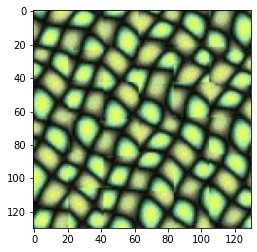

In [457]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('todo.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
img = quilt(img, 25 , (6, 6), "cut")
plt.imshow(img)

(64, 64, 3)
X 0
Y 0
X 21
Y 0
X 42
Y 0
X 63
Y 0
X 84
Y 0
X 105
Y 0
X 0
Y 21
X 21
Y 21
X 42
Y 21
X 63
Y 21
X 84
Y 21
X 105
Y 21
X 0
Y 42
X 21
Y 42
X 42
Y 42
X 63
Y 42
X 84
Y 42
X 105
Y 42
X 0
Y 63
X 21
Y 63
X 42
Y 63
X 63
Y 63
X 84
Y 63
X 105
Y 63
X 0
Y 84
X 21
Y 84
X 42
Y 84
X 63
Y 84
X 84
Y 84
X 105
Y 84
X 0
Y 105
X 21
Y 105
X 42
Y 105
X 63
Y 105
X 84
Y 105
X 105
Y 105


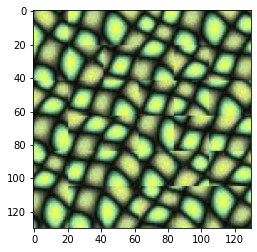

In [398]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('todo.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = quilt(img, 25, (6, 6), "best")
plt.imshow(img)

In [558]:
successfulPatch

array([[[0.28627451, 0.34901961, 0.24313725],
        [0.56078431, 0.60392157, 0.43529412],
        [0.68627451, 0.7254902 , 0.48627451],
        ...,
        [0.12941176, 0.21176471, 0.08235294],
        [0.20392157, 0.27843137, 0.16862745],
        [0.3372549 , 0.4       , 0.29803922]],

       [[0.40392157, 0.4745098 , 0.3254902 ],
        [0.59215686, 0.65098039, 0.42745098],
        [0.80392157, 0.85882353, 0.56470588],
        ...,
        [0.09019608, 0.22352941, 0.07843137],
        [0.03529412, 0.1372549 , 0.03137255],
        [0.05098039, 0.1254902 , 0.05098039]],

       [[0.4745098 , 0.55294118, 0.36078431],
        [0.59607843, 0.67843137, 0.40784314],
        [0.78823529, 0.86666667, 0.5254902 ],
        ...,
        [0.36862745, 0.55686275, 0.36078431],
        [0.24705882, 0.38431373, 0.26666667],
        [0.08627451, 0.18039216, 0.11764706]],

       ...,

       [[0.36078431, 0.52156863, 0.38823529],
        [0.2745098 , 0.42745098, 0.31372549],
        [0.18039216, 0

TypeError: Invalid shape (0,) for image data

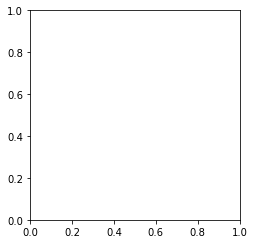

In [581]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
min_val, max_val = 0, 5
matrix = []
for i in range(0,5):
    for j in range(0,5):
        matrix.append(1)
ax.matshow(matrix, cmap='ocean')

for i in range(max_val):
    for j in range(max_val):
       
        ax.text(i, j, str(1))

plt.show()

4


AttributeError: 'AxesImage' object has no property 'title'

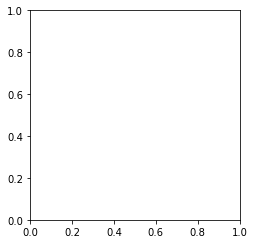

In [589]:

import numpy as np
import matplotlib.pyplot as plt
matrix = []
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
min_val, maxvalue = 0, 5
for i in range(0,2):
    row = []
    for j in range(0,maxvalue):
        row.append(1)
    matrix.append(row)

for i in range(2,4):
    row = []
    for j in range(0,maxvalue):
        row.append(2)
    matrix.append(row)

print(len(matrix))
ax.matshow(matrix, cmap='ocean')

plt.show()

In [678]:
print((int)(51/25))

2


In [690]:
# Create a graph given in the above diagram 
graph = [[0, 16, 13, 0, 0, 0], 
        [0, 0, 10, 12, 0, 0], 
        [0, 4, 0, 0, 14, 0], 
        [0, 0, 9, 0, 0, 20], 
        [0, 0, 0, 7, 0, 4], 
        [0, 0, 0, 0, 0, 0]] 
  
g = Graph(graph) 
  
source = 0; sink = 5
  
left,right,visited = g.minCut(source, sink) 
  
# This code is contributed by Neelam Yadav 


In [691]:
visited

[True, True, True, False, True, False]